## Proyecto Final Logística 
---
<li>Luna Moreno</li>
<li>Carles Adam</li>
<li>Enrique Sayas</li>

## 0. Cargar Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS

from structure import instance, solution
from algorithms import grasp

## 1. Introducción

In [2]:
def resolver(path, alpha):
    inst = instance.readInstance(path)
    sol = grasp.execute(inst, 10, alpha)
    solution.printSolution(sol)
    return sol["sol"]

def visualizar_solucion(path, alpha=None):
    if alpha != None:
        sol = resolver(path, alpha)
    else:
        sol = []

    # Cargar el archivo con las distancias
    distancias = pd.read_table(path, sep = " ", skiprows=1, header=None)
    # Creamos la matriz de distancias
    matriz_distancias = np.zeros([100,100])

    for _ , fila in distancias.iterrows():
        i, j, distancia = fila
        matriz_distancias[int(i),int(j)] = distancia
        matriz_distancias[int(j),int(i)] = distancia

    # Visualizamos su representación en 2D
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=33)
    coordenadas_2d = mds.fit_transform(matriz_distancias)

    # Etiquetas para los puntos (opcional)
    colores = ["#efb810" if i in sol else "black" for i, (x, y) in enumerate(coordenadas_2d)]

    plt.figure(figsize=(6, 6))
    plt.scatter(coordenadas_2d[:, 0], coordenadas_2d[:, 1], color=colores, marker='o')     

    plt.title("Puntos en 2D a partir de la matriz de distancias")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.show()

Iter 1: C -> 224.33, LS -> 343.51
Iter 2: C -> 225.28, LS -> 324.85
Iter 3: C -> 221.95, LS -> 344.91
Iter 4: C -> 224.38, LS -> 331.94
Iter 5: C -> 244.55, LS -> 332.61
Iter 6: C -> 231.79, LS -> 340.63
Iter 7: C -> 250.17, LS -> 352.23
Iter 8: C -> 220.24, LS -> 359.81
Iter 9: C -> 220.61, LS -> 360.15
Iter 10: C -> 216.88, LS -> 344.04
Solution: 1 74 13 80 86 26 31 37 43 57 
Objective Value: 360.15


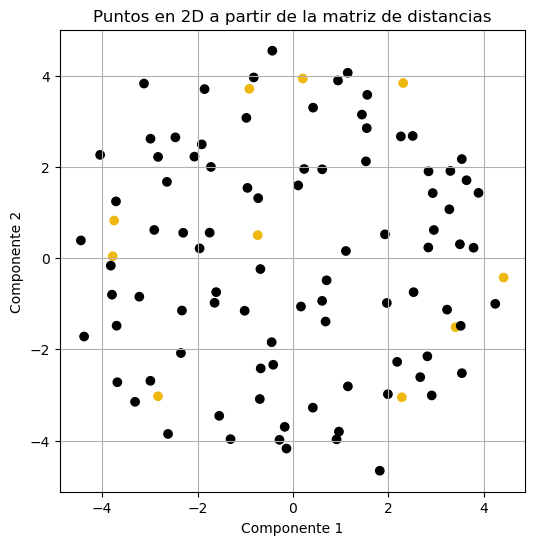

In [15]:
visualizar_solucion("instances/MDG-a_1_100_m10.txt",alpha=0.85)

## 2. Modelo GRASP

### 2.1. Calibrar Alfa

In [3]:
data = pd.read_csv("resultados.csv", sep=";")
data

,archivo,alpha,valor,tiempo
0,MDG-a_10_100_m10,0.00,352.72,0.03
1,MDG-a_10_100_m10,0.05,348.59,0.03
2,MDG-a_10_100_m10,0.10,348.59,0.03
3,MDG-a_10_100_m10,0.15,345.24,0.03
4,MDG-a_10_100_m10,0.20,345.48,0.04
...,...,...,...,...
310,MDG-a_9_n500_m50,0.80,7706.28,4.30
311,MDG-a_9_n500_m50,0.85,7719.05,4.12
312,MDG-a_9_n500_m50,0.90,7693.47,3.98
313,MDG-a_9_n500_m50,0.95,7660.40,6.33


In [4]:
# Calcular el máximo y la desviación estándar
data["Maximo"] = float(0)
for archivo in data["archivo"].unique():
    data.loc[data["archivo"] == archivo,"Maximo"] = data[data["archivo"] == archivo]["valor"].values.max()
data["Dev"] = (data["Maximo"] - data["valor"]) / data["Maximo"]
data

,archivo,alpha,valor,tiempo,Maximo,Dev
0,MDG-a_10_100_m10,0.00,352.72,0.03,355.50,0.007820
1,MDG-a_10_100_m10,0.05,348.59,0.03,355.50,0.019437
2,MDG-a_10_100_m10,0.10,348.59,0.03,355.50,0.019437
3,MDG-a_10_100_m10,0.15,345.24,0.03,355.50,0.028861
4,MDG-a_10_100_m10,0.20,345.48,0.04,355.50,0.028186
...,...,...,...,...,...,...
310,MDG-a_9_n500_m50,0.80,7706.28,4.30,7733.32,0.003497
311,MDG-a_9_n500_m50,0.85,7719.05,4.12,7733.32,0.001845
312,MDG-a_9_n500_m50,0.90,7693.47,3.98,7733.32,0.005153
313,MDG-a_9_n500_m50,0.95,7660.40,6.33,7733.32,0.009429


In [5]:
# Seleccionar el mejor alfa
data.loc[:,["alpha","Dev"]].groupby("alpha").mean("Dev").sort_values("Dev").head()

,Dev
alpha,
0.85,0.007194
0.50,0.007598
0.10,0.008383
0.75,0.008573
0.45,0.008886


In [6]:
data["Color"] = ['Maximo' if x[1]["valor"] == x[1]["Maximo"] else "Otros" for x in data.iterrows()]
data.loc[data["alpha"] == 0.85, "Color"] = "alfa = 0.85"

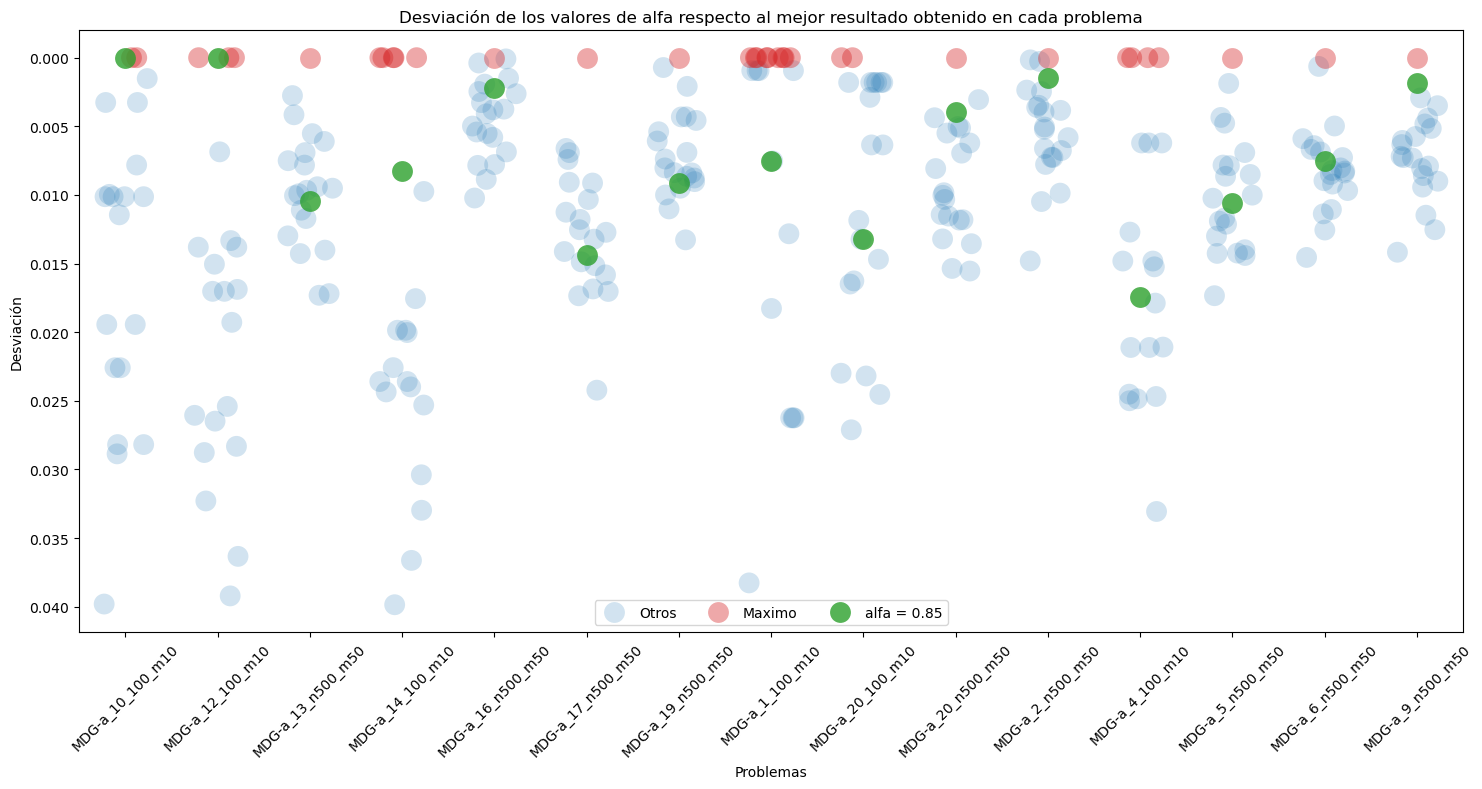

In [7]:
custom_palette = {
    'Otros': '#1f77b4',
    'alfa = 0.85': '#2ca02c',
    'Maximo': '#d62728'
}

fig, ax = plt.subplots(figsize=(15,8))
sns.stripplot(data=data[np.logical_and(data["alpha"] != 0.85, data["valor"] != data["Maximo"])], x="archivo", y="Dev", hue="Color", alpha=0.2, ax=ax, size=15, jitter=0.25, palette=custom_palette)
sns.stripplot(data=data[np.logical_and(data["alpha"] != 0.85, data["valor"] == data["Maximo"])], x="archivo", y="Dev", hue="Color", alpha=0.4, ax=ax, size=15, jitter=0.25, palette=custom_palette)
sns.stripplot(data=data[data["alpha"] == 0.85], x="archivo", y="Dev", hue="Color", alpha=0.8, ax=ax, size=15, jitter=0.25, palette=custom_palette)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Problemas")
ax.set_ylabel("Desviación")
ax.invert_yaxis()
plt.title("Desviación de los valores de alfa respecto al mejor resultado obtenido en cada problema")
plt.legend(ncol=3, loc="lower center", bbox_to_anchor=(0.5, 0))
plt.tight_layout()
plt.show()

## 3. Path Relinking

In [8]:
path_relinking = []

for archivo in data["archivo"].unique():
    df_archivo = data[data["archivo"] == archivo].copy()
    # Ordenar las soluciones por Dev (menor desviación mejor)
    df_archivo = df_archivo.sort_values("Dev")

    if len(df_archivo) >= 2:
        start = df_archivo.iloc[0]
        target = df_archivo.iloc[1]

        # Generar puntos intermedios (por ejemplo, 10 puntos)
        alphas_path = np.linspace(start["alpha"], target["alpha"], num=10)
        valores_path = np.linspace(start["valor"], target["valor"], num=10)

        for alpha_inter, valor_inter in zip(alphas_path, valores_path):
            path_relinking.append({
                "archivo": archivo,
                "alpha": alpha_inter,
                "valor": valor_inter,
                "Maximo": start["Maximo"],  # Usamos el mismo máximo
                "Dev": (start["Maximo"] - valor_inter) / start["Maximo"],
                "Color": "PathRelinking"
            })

# Agregar los puntos de Path Relinking al DataFrame original
data = pd.concat([data, pd.DataFrame(path_relinking)], ignore_index=True)

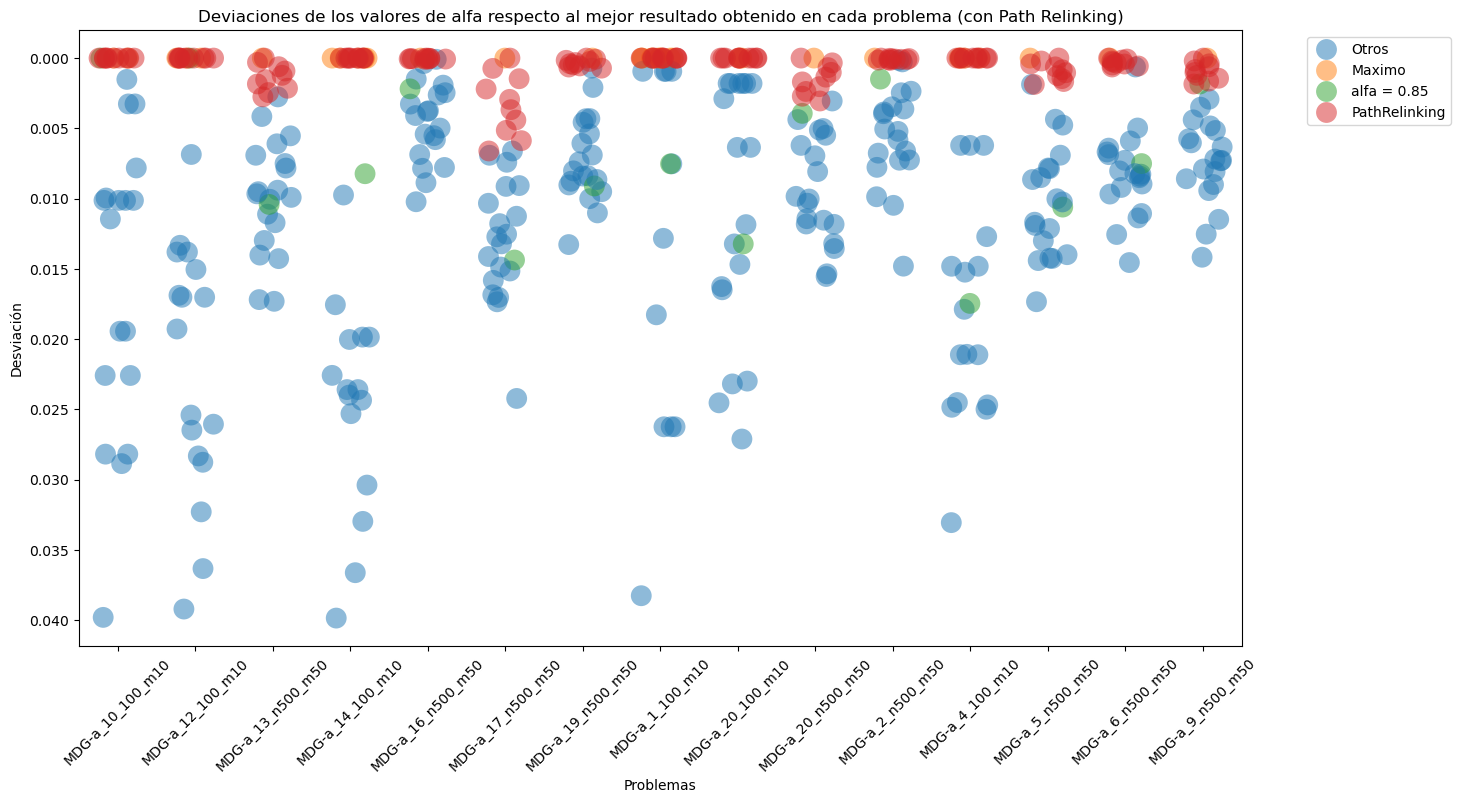

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
sns.stripplot(data=data, x="archivo", y="Dev", hue="Color", alpha=.5, ax=ax, size=15, jitter=0.25)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Problemas")
ax.set_ylabel("Desviación")
ax.set_title("Deviaciones de los valores de alfa respecto al mejor resultado obtenido en cada problema (con Path Relinking)")
ax.invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

La figura muestra la desviación de los valores de alpha respecto al mejor resultado obtenido en cada problema. Las soluciones originales se representan en azul, destacándose en amarillo las mejores soluciones (Maximo) y en verde las correspondientes a alpha = 0.85. Los puntos rojos indican las soluciones generadas mediante Path Relinking, las cuales exploran caminos intermedios entre las mejores configuraciones. Se observa que el Path Relinking tiende a generar soluciones con desviaciones muy bajas, compitiendo favorablemente con los mejores valores originales.

## 4. Comparación

## 5. Conclusiones

## 6. Bibliografía

Resende, M. G. C., Ribeiro, C. C., Glover, F., & Martí, R. (2010). Scatter search and path-relinking: Fundamentals, advances, and applications. En M. Gendreau & J.-Y. Potvin (Eds.), Handbook of Metaheuristics (pp. 87–107). Springer. https://doi.org/10.1007/978-1-4419-1665-5_4